## Multi step feed-forward neural network model (vector output approach) 

In this notebook, we demonstrate how to:

- prepare time series data for training a RNN forecasting model
- get data in the required shape for the keras API
- implement a RNN model in keras to predict the next 3 steps ahead (time t+1 to t+3) in the time series. This model uses a simple encoder decoder approach in which the final hidden state of the encoder is replicated across each time step of the decoder.
- enable early stopping to reduce the likelihood of model overfitting
- evaluate the model on a test dataset

The data in this example is taken from the GEFCom2014 forecasting competition1. It consists of 3 years of hourly electricity load and temperature values between 2012 and 2014. The task is to forecast future values of electricity load.

1Tao Hong, Pierre Pinson, Shu Fan, Hamidreza Zareipour, Alberto Troccoli and Rob J. Hyndman, "Probabilistic energy forecasting: Global Energy Forecasting Competition 2014 and beyond", International Journal of Forecasting, vol.32, no.3, pp 896-913, July-September, 2016.

In [1]:
import sys
sys.path.append('..')
import os
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import datetime as dt
from glob import glob
from collections import UserDict
from common.utils import *
from IPython.display import Image
%matplotlib inline

pd.options.display.float_format = '{:,.2f}'.format
np.set_printoptions(precision=2)
warnings.filterwarnings("ignore")

In [2]:
# Load data into Pandas dataframe
data_dir = 'data'
energy = load_data(data_dir)
energy.head()

,load,temp
2012-01-01 00:00:00,"2,698.00",32.00
2012-01-01 01:00:00,"2,558.00",32.67
2012-01-01 02:00:00,"2,444.00",30.00
2012-01-01 03:00:00,"2,402.00",31.00
2012-01-01 04:00:00,"2,403.00",32.00


In [3]:
valid_start_dt = '2014-09-01 00:00:00'
test_start_dt = '2014-11-01 00:00:00'

## Data Preparation

For this example, we will set T=6. This means that the input for each sample is a vector of the prevous 6 hours of the energy load. The choice of T=6 was arbitrary but should be selected through experimentation.

HORIZON=3 specifies that we have a forecasting horizon of 3 (t+1, t+2, t+3)

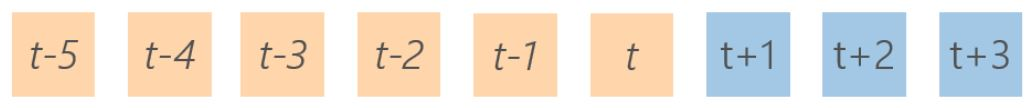

In [4]:
Image('images/multistep_forecast.JPG')

In [5]:
T = 6
HORIZON = 3

### Select data for training set

In [6]:
train = energy.copy()[energy.index < valid_start_dt][['load', 'temp']]

Scale data to be in range (0, 1). **This transformation should be calibrated on the training set only.** 

This is to prevent information from the validation or test sets leaking into the training data.

In [7]:
from sklearn.preprocessing import MinMaxScaler

y_scaler = MinMaxScaler()
y_scaler.fit(train[['load']])

# here we need to scale the two input features
X_scaler = MinMaxScaler()
train[['load', 'temp']] = X_scaler.fit_transform(train)

Use the **TimeSeriesTensor** convenience class to:

- Shift the values of the time series to create a Pandas dataframe containing all the data for a single training example
- Discard any samples with missing values
- Transform this Pandas dataframe into a numpy array of shape (samples, time steps, features) for input into Keras

The class takes the following parameters:

- **dataset**: original time series
- **H**: the forecast horizon
- **tensor_structure**: a dictionary discribing the tensor structure in the form { 'tensor_name' : (range(max_backward_shift, max_forward_shift), [feature, feature, ...] ) }
- **freq**: time series frequency
- **drop_incomplete**: (Boolean) whether to drop incomplete samples

In [8]:
tensor_structure = {'X':(range(-T+1, 1), ['load', 'temp'])}
train_inputs = TimeSeriesTensor(train, 'load', HORIZON, {'X':(range(-T+1, 1), ['load', 'temp'])})

In [9]:
train_inputs.dataframe.head()

tensor              target              X                                     \
feature                  y           load                          temp        
time step              t+1  t+2  t+3  t-5  t-4  t-3  t-2  t-1    t  t-5  t-4   
2012-01-01 05:00:00   0.18 0.23 0.29 0.22 0.18 0.14 0.13 0.13 0.15 0.42 0.43   
2012-01-01 06:00:00   0.23 0.29 0.35 0.18 0.14 0.13 0.13 0.15 0.18 0.43 0.40   
2012-01-01 07:00:00   0.29 0.35 0.37 0.14 0.13 0.13 0.15 0.18 0.23 0.40 0.41   
2012-01-01 08:00:00   0.35 0.37 0.37 0.13 0.13 0.15 0.18 0.23 0.29 0.41 0.42   
2012-01-01 09:00:00   0.37 0.37 0.37 0.13 0.15 0.18 0.23 0.29 0.35 0.42 0.41   

tensor                                   
feature                                  
time step            t-3  t-2  t-1    t  
2012-01-01 05:00:00 0.40 0.41 0.42 0.41  
2012-01-01 06:00:00 0.41 0.42 0.41 0.40  
2012-01-01 07:00:00 0.42 0.41 0.40 0.39  
2012-01-01 08:00:00 0.41 0.40 0.39 0.39  
2012-01-01 09:00:00 0.40 0.39 0.39 0.43

- Here we need select the load and temp features

In [10]:
X_train = train_inputs.dataframe.values[:,HORIZON:]

In [11]:
X_train[0:4]

array([[0.22, 0.18, 0.14, 0.13, 0.13, 0.15, 0.42, 0.43, 0.4 , 0.41, 0.42,
        0.41],
       [0.18, 0.14, 0.13, 0.13, 0.15, 0.18, 0.43, 0.4 , 0.41, 0.42, 0.41,
        0.4 ],
       [0.14, 0.13, 0.13, 0.15, 0.18, 0.23, 0.4 , 0.41, 0.42, 0.41, 0.4 ,
        0.39],
       [0.13, 0.13, 0.15, 0.18, 0.23, 0.29, 0.41, 0.42, 0.41, 0.4 , 0.39,
        0.39]])

### Validation set 

Keeping T hours from the training set in order to construct initial features

In [12]:
look_back_dt = dt.datetime.strptime(valid_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
valid = energy.copy()[(energy.index >=look_back_dt) & (energy.index < test_start_dt)][['load', 'temp']]
valid[['load', 'temp']] = X_scaler.transform(valid)
valid_inputs = TimeSeriesTensor(valid, 'load', HORIZON, tensor_structure)

X_valid = valid_inputs.dataframe.values[:,HORIZON:]
X_valid.shape

(1461, 12)

## Implement feed-forward neural network
We implement feed-forward neural network with the following structure:

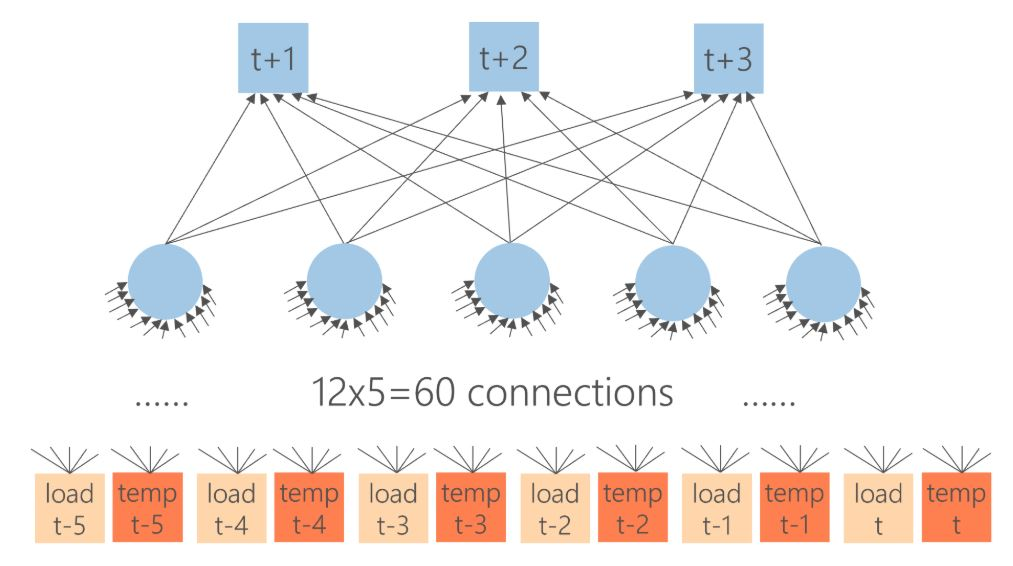

In [13]:
Image("images/ff_multi_step_vector_output.JPG")

In [14]:
from keras.models import Model, Sequential
from keras.layers import GRU, Dense
from keras.callbacks import EarlyStopping, ModelCheckpoint

Using TensorFlow backend.


In [15]:
LATENT_DIM = 5
BATCH_SIZE = 32
EPOCHS = 50

In [16]:
model = Sequential()
model.add(Dense(LATENT_DIM, activation="relu", input_shape=(2*T,)))
model.add(Dense(HORIZON))

W0301 14:25:13.400793 15888 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0301 14:25:13.424796 15888 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0301 14:25:13.427786 15888 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



In [17]:
model.compile(optimizer='RMSprop', loss='mse')
model.summary()

W0301 14:25:13.491785 15888 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 5)                 65        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 18        
Total params: 83
Trainable params: 83
Non-trainable params: 0
_________________________________________________________________


In [18]:
earlystop = EarlyStopping(monitor='val_loss', min_delta=0, patience=5)

In [19]:
best_val = ModelCheckpoint('model_{epoch:02d}.h5', save_best_only=True, mode='min', period=1)

In [20]:
y_train = train_inputs['target']
y_valid = valid_inputs['target']

history = model.fit(X_train, y_train,
                    batch_size=BATCH_SIZE, epochs=EPOCHS,
                    validation_data=(X_valid, y_valid),
                    callbacks=[earlystop, best_val],verbose=1)

W0301 14:25:13.673808 15888 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.

W0301 14:25:13.680784 15888 deprecation_wrapper.py:119] From c:\users\ctw00071\appdata\local\continuum\miniconda3\envs\neuralnets\lib\site-packages\keras\backend\tensorflow_backend.py:973: The name tf.assign is deprecated. Please use tf.compat.v1.assign instead.



Train on 23368 samples, validate on 1461 samples
Epoch 1/50
23368/23368 [==============================] - 1s 36us/step - loss: 0.0118 - val_loss: 0.0058
Epoch 2/50
23368/23368 [==============================] - 1s 28us/step - loss: 0.0057 - val_loss: 0.0055
Epoch 3/50
23368/23368 [==============================] - 1s 30us/step - loss: 0.0048 - val_loss: 0.0040
Epoch 4/50
23368/23368 [==============================] - 1s 35us/step - loss: 0.0044 - val_loss: 0.0039
Epoch 5/50
23368/23368 [==============================] - 1s 29us/step - loss: 0.0042 - val_loss: 0.0053
Epoch 6/50
23368/23368 [==============================] - 1s 30us/step - loss: 0.0041 - val_loss: 0.0040
Epoch 7/50
23368/23368 [==============================] - 1s 30us/step - loss: 0.0039 - val_loss: 0.0037
Epoch 8/50
23368/23368 [==============================] - 1s 29us/step - loss: 0.0039 - val_loss: 0.0037
Epoch 9/50
23368/23368 [==============================] - 1s 28us/step - loss: 0.0038 - val_loss: 0.0042
Epoch 

## Evaluate Model

Load the model with the smallest mape

In [21]:
best_epoch = np.argmin(np.array(history.history['val_loss']))+1
model.load_weights("model_{:02d}.h5".format(best_epoch))

In [22]:
look_back_dt = dt.datetime.strptime(test_start_dt, '%Y-%m-%d %H:%M:%S') - dt.timedelta(hours=T-1)
test = energy.copy()[test_start_dt:][['load', 'temp']]
test[['load', 'temp']] = X_scaler.transform(test)
test_inputs = TimeSeriesTensor(test, 'load', HORIZON, tensor_structure)

X_test = test_inputs.dataframe.values[:,HORIZON:]
X_test.shape

(1456, 12)

In [23]:
predictions = model.predict(X_test)

In [24]:
predictions

array([[0.21, 0.26, 0.33],
       [0.29, 0.35, 0.41],
       [0.37, 0.43, 0.48],
       ...,
       [0.63, 0.56, 0.48],
       [0.56, 0.49, 0.42],
       [0.51, 0.45, 0.39]], dtype=float32)

In [25]:
eval_df = create_evaluation_df(predictions, test_inputs, HORIZON, y_scaler)
eval_df.head()

,timestamp,h,prediction,actual
0,2014-11-01 05:00:00,t+1,"2,660.68","2,714.00"
1,2014-11-01 06:00:00,t+1,"2,930.22","2,970.00"
2,2014-11-01 07:00:00,t+1,"3,184.13","3,189.00"
3,2014-11-01 08:00:00,t+1,"3,366.50","3,356.00"
4,2014-11-01 09:00:00,t+1,"3,465.84","3,436.00"


Compute MAPE for each forecast horizon

In [26]:
eval_df['APE'] = (eval_df['prediction'] - eval_df['actual']).abs() / eval_df['actual']
eval_df.groupby('h')['APE'].mean()

h
t+1   0.02
t+2   0.04
t+3   0.06
Name: APE, dtype: float64

Compute MAPE across all predictions

In [27]:
mape(eval_df['prediction'], eval_df['actual'])

0.040263814044455795

Plot actuals vs predictions at each horizon for first week of the test period. As is to be expected, predictions for one step ahead (t+1) are more accurate than those for 2 or 3 steps ahead

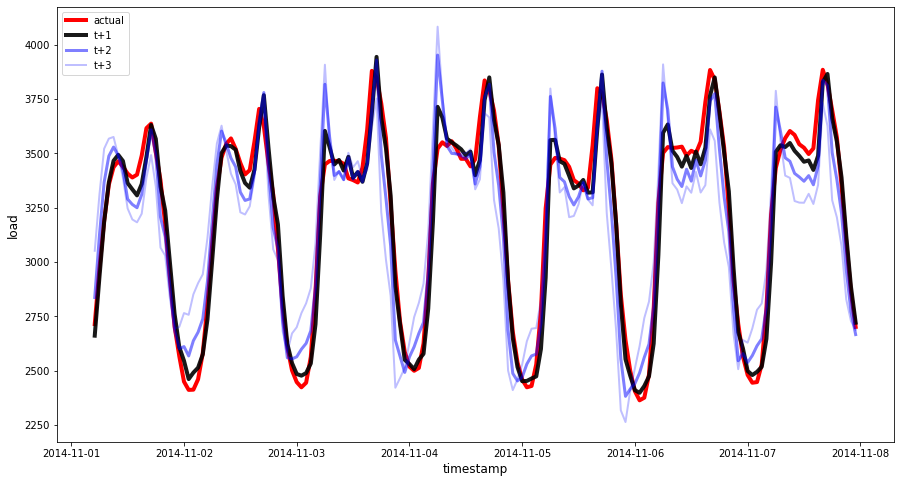

In [31]:
plot_df = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+1')][['timestamp', 'actual']]
for t in range(1, HORIZON+1):
    plot_df['t+'+str(t)] = eval_df[(eval_df.timestamp<'2014-11-08') & (eval_df.h=='t+'+str(t))]['prediction'].values

fig = plt.figure(figsize=(15, 8))
ax = plt.plot(plot_df['timestamp'], plot_df['actual'], color='red', linewidth=4.0, label='actual')
ax = fig.add_subplot(111)
ax.plot(plot_df['timestamp'], plot_df['t+1'], color='black', linewidth=4.0, alpha=0.90, label='t+1')
ax.plot(plot_df['timestamp'], plot_df['t+2'], color='blue', linewidth=3.0, alpha=0.5, label='t+2')
ax.plot(plot_df['timestamp'], plot_df['t+3'], color='blue', linewidth=2.0, alpha=0.25, label='t+3')
plt.xlabel('timestamp', fontsize=12)
plt.ylabel('load', fontsize=12)
ax.legend(loc='best')
plt.show()

In [32]:
for m in glob('model_*.h5'):
    os.remove(m)